**Deep Learning September Project - Annisaa Fitri Nurfirdausi - 0001110915**

# **Sea Surface Temperature Reconstruction under Cloud Occlusion**
Sea Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.
We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.

## **1. Data Download and Loading**

In [ ]:
# Download data files
!gdown 1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
!gdown 1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
!gdown 1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
!gdown 1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
!gdown 1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
!gdown 1hGg-J7ipuil1Hp46YTIVWzXkSHc2avBE
!gdown 1F0GGmrrGtSHizdf0COyHErNqMf9FazCK
!gdown 1JfVhw5HHlUOj_3UxVFT-kTaOVs6ZRUEJ


Downloading...
From: https://drive.google.com/uc?id=1cxZCt2CzMo9AolJ9k-je3b4w9t0Ibpvc
To: /content/x_test_night.npy
100% 58.7M/58.7M [00:00<00:00, 106MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY
From (redirected): https://drive.google.com/uc?id=1L3PxazNUnc_cw9XvHfj_J-fhhBXv41YY&confirm=t&uuid=a9807be9-ae9e-48dc-b43e-175dead29fb6
To: /content/x_train_night.npy
100% 382M/382M [00:03<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tR7U8ndBktwiAhmpyQZG2nv5kRcX0mtd
To: /content/x_val_night.npy
100% 71.4M/71.4M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ROGlbqknu47uyZs89J1oBml6vwE-wtfx
To: /content/dates_test_night.npy
100% 3.71k/3.71k [00:00<00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wpKfWxwf9XXJixdUrrjN-idcAZ5H3-0C
To: /content/dates_train_night.npy
100% 23.5k/23.5k [00:00<00:00, 52.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hGg-J7ipuil

In [ ]:
# Load data
import numpy as np

x_train_n = np.load('/content/x_train_night.npy')
x_val_n = np.load('/content/x_val_night.npy')
x_test_n = np.load('/content/x_test_night.npy')

dates_train_n = np.load('/content/dates_train_night.npy')
dates_val_n = np.load('/content/dates_val_night.npy')
dates_test_n = np.load('/content/dates_test_night.npy')

land_sea_mask = np.load('/content/land_sea_mask.npy')
baseline = np.load('/content/stat_baseline.npy')
total_sea = np.sum(land_sea_mask)

## **2. Data Inspection**

x_train_n shape: (5832, 128, 128)
x_val_n shape: (1090, 128, 128)
x_test_n shape: (895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049
land_sea_mask shape: (128, 128)


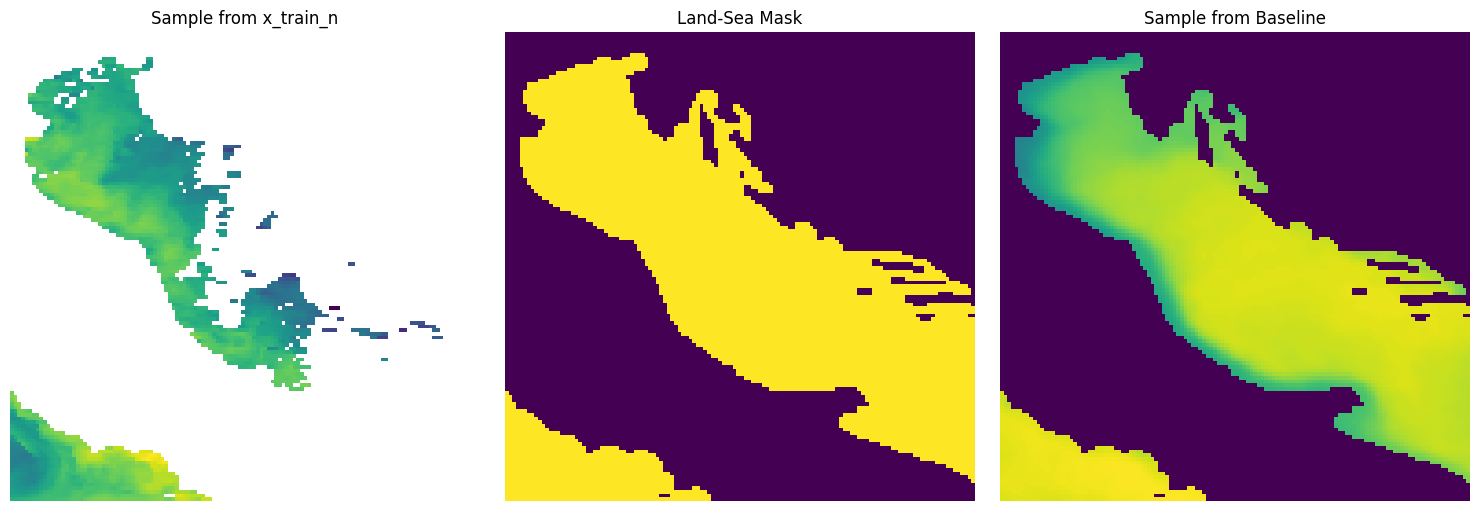

In [ ]:
import matplotlib.pyplot as plt

# Print shapes and basic statistics
print(f"x_train_n shape: {x_train_n.shape}")
print(f"x_val_n shape: {x_val_n.shape}")
print(f"x_test_n shape: {x_test_n.shape}")

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}")

print(f"land_sea_mask shape: {land_sea_mask.shape}")

def plot_samples(images, title='Samples', rows=1, cols=3):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 5))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#sample from x_train_n
axes[0].imshow(x_train_n[0])
axes[0].set_title('Sample from x_train_n')
axes[0].axis('off')

#land_sea_mask
axes[1].imshow(land_sea_mask)
axes[1].set_title('Land-Sea Mask')
axes[1].axis('off')

#baseline
axes[2].imshow(baseline[0])
axes[2].set_title('Sample from Baseline')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## **3. Data Normalization**

We normalize the training, validation, and test datasets using the mean and standard deviation of the training set. For the baseline data, normalization was applied only in valid regions as defined by the land-sea mask, with masked-out regions set to zero.

In [ ]:
# Normalize data
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

# Normalize baseline
baseline_nan = np.where(land_sea_mask, baseline, np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask, baseline_nan, 0.0)

## **4. Data Generator**

The generator function creates batches of training data for a model. A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.  Each batch includes the masked images, artificial and land-sea masks, and baseline adjustments. The target output consists of the original images, corrected masks, and difference masks.

In [ ]:
import pandas as pd

def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            found = False
            while not found:
                i = np.random.randint(0, dataset.shape[0])
                visible = np.sum(~np.isnan(dataset[i])) / total_sea
                if visible > 0.4:
                    found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            found = False
            while not found:
                r = np.random.randint(0, dataset.shape[0])
                mask_r = np.isnan(dataset[r])
                mask_or_r = np.logical_or(mask_current, mask_r)
                nnans = np.sum(~mask_or_r) / total_sea
                if nnans > 0.05 and nnans < min(visible - .1, 0.4):
                    found = True

            artificial_mask_current = ~mask_or_r

            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current, baseline[day_of_year - 1], np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline
            tuned_baseline = np.where(land_sea_mask, tuned_baseline, .0)

            mask_current = np.logical_not(mask_current)
            diff_mask = np.logical_and(~artificial_mask_current, mask_current)

            batch_x[b, ..., 0] = image_masked_current
            batch_x[b, ..., 1] = artificial_mask_current
            batch_x[b, ..., 2] = land_sea_mask
            batch_x[b, ..., 3] = tuned_baseline

            batch_y[b, ..., 0] = image_current
            batch_y[b, ..., 1] = mask_current
            batch_y[b, ..., 2] = diff_mask

        yield batch_x, batch_y

In [ ]:
batch_size = 32
train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

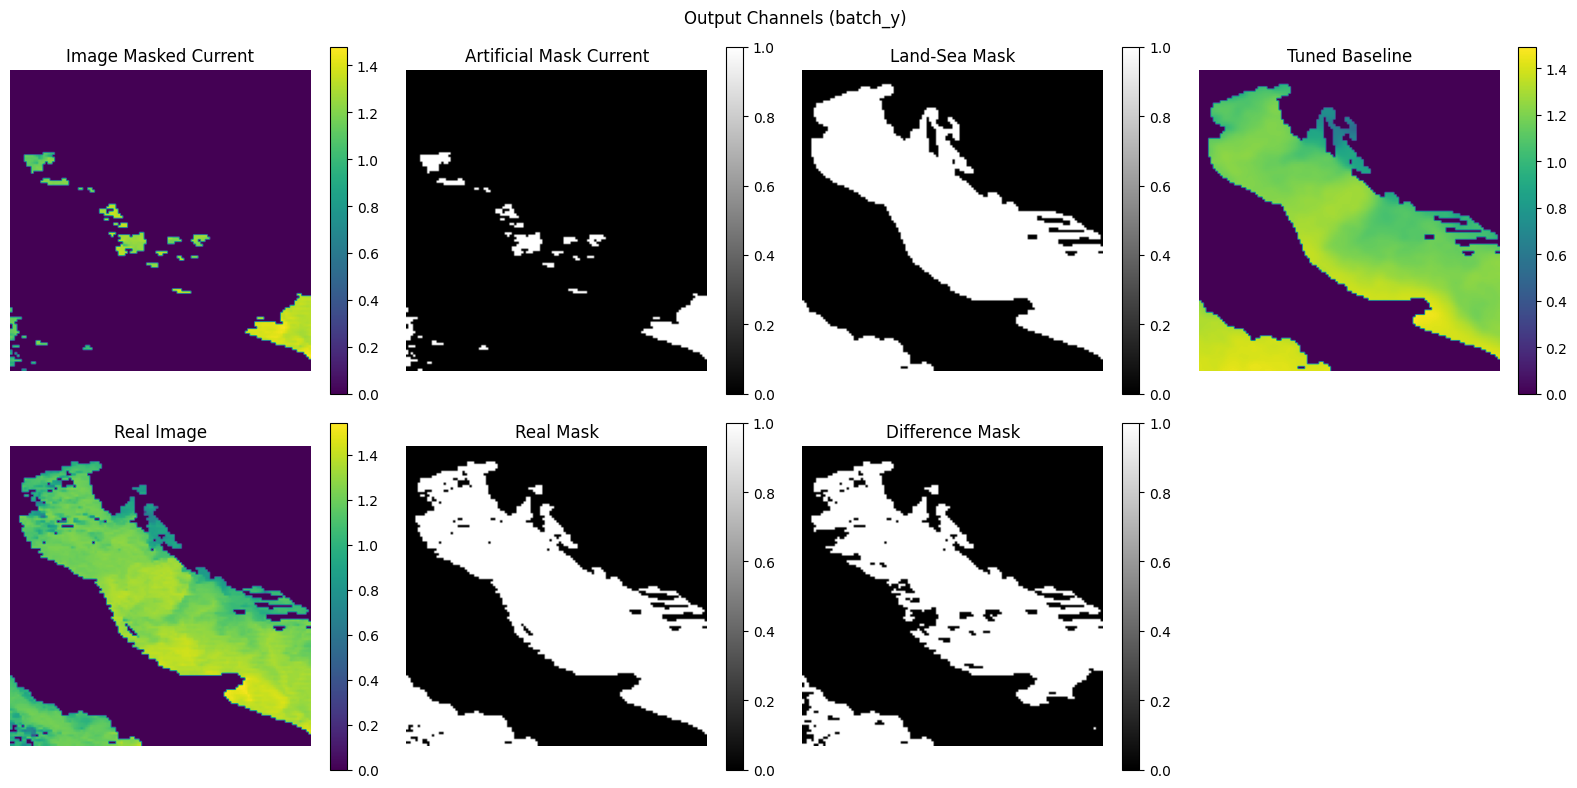

In [ ]:
batch_size = 32
train_gen = generator(batch_size, x_train_n, dates_train_n)
batch_x, batch_y = next(train_gen)

sample_index = 0

### Visualisation ###
def plot_channel(channel, title, cmap='viridis'):
    plt.imshow(channel, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.axis('off')

plt.figure(figsize=(16, 8))

plt.suptitle('Input Channels (batch_x)')
plt.subplot(2, 4, 1)
plot_channel(batch_x[sample_index, ..., 0], 'Image Masked Current')

plt.subplot(2, 4, 2)
plot_channel(batch_x[sample_index, ..., 1], 'Artificial Mask Current', cmap='gray')

plt.subplot(2, 4, 3)
plot_channel(batch_x[sample_index, ..., 2], 'Land-Sea Mask', cmap='gray')

plt.subplot(2, 4, 4)
plot_channel(batch_x[sample_index, ..., 3], 'Tuned Baseline')


plt.suptitle('Output Channels (batch_y)')
plt.subplot(2, 4, 5)
plot_channel(batch_y[sample_index, ..., 0], 'Real Image')

plt.subplot(2, 4, 6)
plot_channel(batch_y[sample_index, ..., 1], 'Real Mask', cmap='gray')

plt.subplot(2, 4, 7)
plot_channel(batch_y[sample_index, ..., 2], 'Difference Mask', cmap='gray')

plt.tight_layout()
plt.show()

The data generator is designed to yield batches of input (batch_x) and output (batch_y) data for training a neural network model. Each batch is constructed to contain multiple samples of both input and target data.

batch_x - Represents the input data for the model and consists of four components:
- Real image of the day.
- The input passed to the model, that is a masked version of the previous image.
- Land-sea masks that help the model distinguish between land and water areas in the images.
- Tuned baseline images - the tentative reconstruction done via the statistical baseline.

batch_y - Represents the target data (ground truth) and consists of three components:
- Real (unmasked) images that the mask of the current day
- Real masks that serve as accurate references for segmentation tasks.
- Difference masks that indicate the discrepancies between the masked input and the real, unmasked image, aiding in the model's learning of restoration tasks.

## **5. Training the Model**

We use a custom loss function instead of a built-in loss function because we want the model to focus specifically on the occluded regions of the image, which are defined by the artificial mask and correspond to the differences between the first channel of y_true and y_pred. This mask highlights the areas where data is missing or corrupted. The custom loss calculates the Root Mean Squared Error (RMSE) only in these specific regions.

We also monitor the RMSE during training, but note that this value represents the RMSE before denormalization. It is important to remember that, for final evaluation, we need to denormalize the data to obtain the true RMSE. Despite this, tracking the pre-denormalized RMSE provides useful insights into the model's performance throughout training.

The model we used is a U-Net architecture, an encoder-decoder architecture with skip connections to preserve spatial information. The encoder comprises convolutional layers with batch normalization, dropout for regularization, and max-pooling for reducing dimensionality while extracting higher-level features. The bottleneck layer further refines these features with deeper convolutions. The decoder reconstructs the output by upsampling and merging with corresponding encoder features, effectively combining both detailed and abstract information. The output layer consists of 3 channels with a linear activation function, and the model is trained using the Adam optimizer and a custom loss function. This design is inspired by the work of Wang et al. (2024), which highlighted the suitability of U-Net for this particular task.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="custom_loss")

def custom_loss(y_true, y_pred):
    # first channel of y and the occluded region
    y_true_channel = tf.cast(y_true[..., 0], tf.float32)
    y_pred_channel = tf.cast(y_pred[..., 0], tf.float32)

    # artificial mask (third channel) from y_true
    artificial_mask = tf.cast(y_true[..., 2], tf.float32)
    squared_diff = tf.square(y_pred_channel - y_true_channel)

    masked_squared_diff = tf.multiply(squared_diff, artificial_mask)

    # mean squared error in the masked regions
    mse = tf.reduce_sum(masked_squared_diff) / tf.maximum(tf.reduce_sum(artificial_mask), 1)

    rmse = tf.sqrt(mse)
    return rmse

def build_unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder: Downsampling path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.2)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(b1)
    b1 = layers.Dropout(0.3)(b1)

    # Decoder: Upsampling path
    u1 = layers.UpSampling2D((2, 2))(b1)
    u1 = layers.Conv2D(256, (2, 2), activation='relu', padding='same')(u1)
    u1 = layers.concatenate([u1, c3])
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.2)(c4)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.Conv2D(128, (2, 2), activation='relu', padding='same')(u2)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.1)(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(u3)
    u3 = layers.concatenate([u3, c1])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.Dropout(0.1)(c6)

    # Output layer with 3 channels for SST, real mask, and diff mask
    outputs = layers.Conv2D(3, (1, 1), activation='linear')(c6)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_loss])

    return model

input_shape = (128, 128, 4)  # Input shape: 4 channels
model = build_unet_model(input_shape)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 128, 128, 64)   │          2,368 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_26    │ (None, 128, 128, 64)   │            256 │ conv2d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_43[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 64, 64, 64)     │              0 │ dropout_9[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_27    │ (None, 64, 64, 128)    │            512 │ conv2d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 128)    │              0 │ conv2d_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 128)    │              0 │ dropout_10[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_28    │ (None, 32, 32, 256)    │          1,024 │ conv2d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 256)    │              0 │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 256)    │              0 │ dropout_11[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 7,703,683 (29.39 MB)

 Trainable params: 7,700,867 (29.38 MB)

 Non-trainable params: 2,816 (11.00 KB)

The code trains a model using Keras over 150 epochs with a batch size of 32. It uses three callbacks: ModelCheckpoint to save the best model based on the lowest validation loss, EarlyStopping to stop training if there's no improvement in validation loss for 10 epochs, and ReduceLROnPlateau to reduce the learning rate by a factor of 0.2 if the validation loss doesn't improve for 3 epochs. After training, the model is saved in .h5 format, and the final training and validation RMSE are printed.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 150
batch_size = 32

checkpoint_filepath = '/content/drive/MyDrive/ign/trial_model.keras'

# defining callbacks
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='min', min_lr=1e-6)
callbacks = [checkpoint, early_stopping, reduce_lr]

# train the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(x_train_n) // batch_size,
    validation_data=val_gen,
    validation_steps=len(x_val_n) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)


# load and save the model

from tensorflow.keras.models import load_model

model = load_model(checkpoint_filepath, custom_objects={"custom_loss": custom_loss})
h5_filepath = '/content/drive/MyDrive/ign/trial2_model.h5'
model.save(h5_filepath)

print(f"Final Training RMSE: {history.history['custom_loss'][-1]}")
print(f"Final Validation RMSE: {history.history['val_custom_loss'][-1]}")


Epoch 1/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - custom_loss: 0.3961 - loss: 0.3961
Epoch 1: val_loss improved from inf to 0.52561, saving model to /content/drive/MyDrive/ign/trial_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 110s 468ms/step - custom_loss: 0.3954 - loss: 0.3954 - val_custom_loss: 0.5256 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - custom_loss: 0.1885 - loss: 0.1885
Epoch 2: val_loss improved from 0.52561 to 0.29721, saving model to /content/drive/MyDrive/ign/trial_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 87s 479ms/step - custom_loss: 0.1885 - loss: 0.1885 - val_custom_loss: 0.2972 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 3/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - custom_loss: 0.1858 - loss: 0.1858
Epoch 3: val_loss improved from 0.29721 to 0.21597, saving model to /content/drive/MyDrive/ign/trial_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 88s 484ms/step - custom_loss: 0.1859 - loss: 0.1859 - val_c

Final Training RMSE: 0.12876257300376892
Final Validation RMSE: 0.10481297224760056


the training process experienced a series of epochs where the validation loss did not improve, leading to reductions in the learning rate as part of the learning rate scheduling. Despite this, the model's performance showed limited improvement, with the final training RMSE at 0.1288 and validation RMSE at 0.1048. Early stopping was triggered to halt training after 10 epochs the val_loss does not improve.

## **6. Evaluate the Model**

In [ ]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0) [...,0]
    #predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.48363377078978304
RMSE std : 0.16415793051979255


Predictions shape: (32, 128, 128)
True values shape: (32, 128, 128)
RMSE for the batch: 0.5113543979586412
RMSE std for the batch: 0.1650940603330354


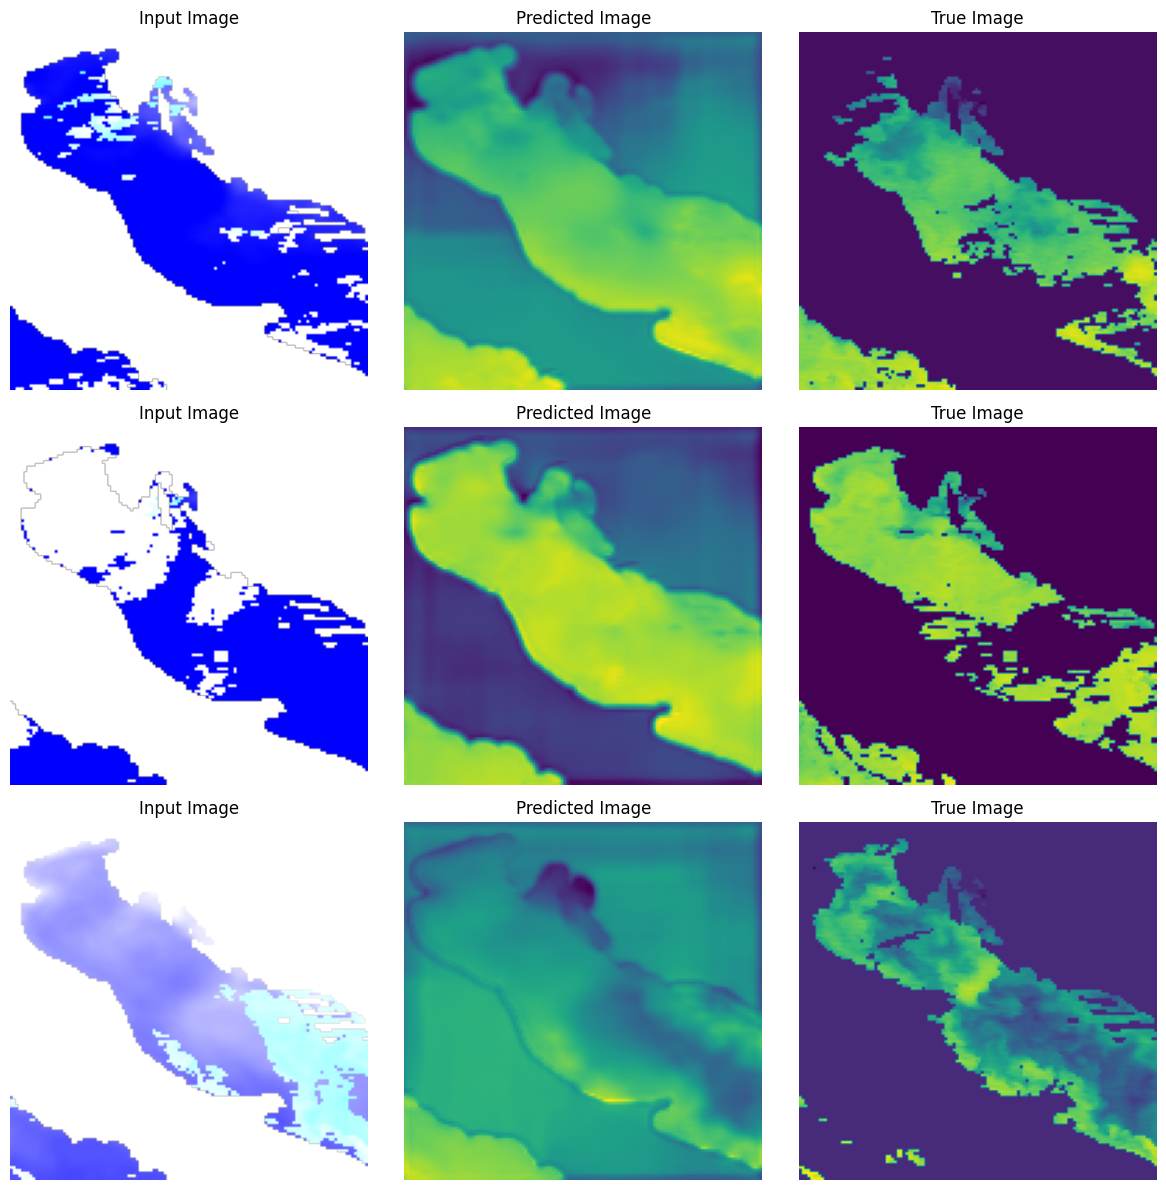

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

RMSE = []


batch_x, batch_y = next(test_gen)

predictions = model.predict(batch_x, verbose=0)[..., 0]

# Denormalize !!!
predictions_denorm = predictions * x_train_std + x_train_mean
true_values_denorm = batch_y[..., 0] * x_train_std + x_train_mean

print(f"Predictions shape: {predictions_denorm.shape}")
print(f"True values shape: {true_values_denorm.shape}")


diffMask = batch_y[..., 2]
diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))
batch_rmse = np.sqrt(squared_errors)
RMSE.extend(batch_rmse)


print(f"RMSE for the batch: {np.mean(batch_rmse)}")
print(f"RMSE std for the batch: {np.std(batch_rmse)}")

#few samples to visualized
num_samples_to_show = 3
fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))

for i in range(num_samples_to_show):
    if batch_x[i].shape[-1] == 1:
        axes[i, 0].imshow(batch_x[i, ..., 0], cmap='gray')
        axes[i, 1].imshow(predictions_denorm[i, ..., 0], cmap='gray')
        axes[i, 2].imshow(true_values_denorm[i, ..., 0], cmap='gray')
    else:
        axes[i, 0].imshow(batch_x[i, ...])
        axes[i, 1].imshow(predictions_denorm[i, ...])
        axes[i, 2].imshow(true_values_denorm[i, ...])

    axes[i, 0].set_title('Input Image')
    axes[i, 1].set_title('Predicted Image')
    axes[i, 2].set_title('True Image')

    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout()
plt.show()


## **7. Conclusion**

- U-Net Model: The U-Net architecture is great for tasks needing detailed spatial information, due to its encoder-decoder design and skip connections.
- Training Results: The final training RMSE was 0.1288, and the validation RMSE was 0.1048. With an overall RMSE of 0.4836 ± 0.1642, there's some variability in predictions.
- Loss Function: The custom loss function focuses on specific areas of interest, in this case the missing data.


## **8. Previous Attempt**

Previously we used u-net architecture with lower parameters around 1.8M. It yielded RMSE around 0.5. Even though it is better than the baseline, but it is still lower than the current result of RMSE.


## **Reference**

[1] Wang, C., Sun, L., Huang, B., Zhang, D., Mu, J., & Wu, J. (2024). Title of the paper. Remote Sensing, 16(7), 1205. https://doi.org/10.3390/rs16071205

[2] TensorFlow. (n.d.). TensorFlow. TensorFlow. Retrieved September 8, 2024, from https://www.tensorflow.org